# Energy equation

Apart from the magnetisation field (and dynamics equation), energy equation must be defined for a micromagnetic system. In this tutorial, we explore how an energy equation can be specified in Ubermag.

The Ubermag subpackage we use for defining micromagnetic models is `micromagneticmodel` and `discretisedfield` we are going to use for defining magnetisation field.

In [33]:
import discretisedfield as df
import micromagneticmodel as mm

As an example, let us define a one-dimensional chain of magnetic moments.

In [34]:
p1 = (0, 0, 0)
p2 = (10e-9, 1e-9, 1e-9)
n = (10, 1, 1)

region = df.Region(p1=p1, p2=p2)
mesh = df.Mesh(region=region, n=n)

mesh.k3d()

Output()

To demonstrate how an energy equation is specified, we are first going to have a look at Exchange and DMI individually and then use them both in our energy equation.

### Exchange energy term

We use $A = 8 \,\text{pJ}\,\text{m}^{-1}$ on a non-uniform magnetisation configuration with $M_\text{s} = 1 \times 10^{6} \,\text{Am}^{-1}$.

In [35]:
system = mm.System(name='exchange')
system.energy = mm.Exchange(A=8e-12)

Ms = 1e6  # saturation magnetisation (A/m)

def m_initial(point):
    x, y, z = point
    if x <= 5e-9:
        return (0, 1, 1)
    else:
        return (1, 0, 0)
    
system.m = df.Field(mesh, dim=3, value=m_initial, norm=Ms)
system.m.k3d_vector(head_size=3)

Output()

The energy equation is

In [36]:
system.energy

Exchange(A=8e-12)

Now, let us relax the system:

In [37]:
import oommfc as mc

md = mc.MinDriver()
md.drive(system)

system.m.k3d_vector(head_size=3)

Running OOMMF (ExeOOMMFRunner) [2020/06/25 14:27]... (1.8 s)


Output()

### Dzyaloshinskii-Moriya energy term

There are two parameters that must be defined for Dzyaloshinskii-Moriya energy term. The first one is the DMI energy constant $D$ and the other is the crystalographic class. Crystalographic class can be: `T`, `O`, `Cnv`, or `D2d`.

Again, we demonstrate its effect by starting from a uniform configuration, with $D = 3 \,\text{mJ}\,\text{m}^{-2}$ and crystallographic class T.

In [38]:
system = mm.System(name='dmi')
system.energy = mm.DMI(D=3e-3, crystalclass='T')
system.m = df.Field(mesh, dim=3, value=(0, 0, 1), norm=Ms)

md.drive(system)

system.m.k3d_vector(head_size=3)

Running OOMMF (ExeOOMMFRunner) [2020/06/25 14:28]... (1.7 s)


Output()

The energy equation is

In [39]:
system.energy

DMI(D=0.003, crystalclass='T')

Now, we can change the crystallographic class to Cnv and see what happens to the relaxed magnetisation.

In [40]:
system.energy.dmi.crystalclass = 'Cnv'
system.energy

DMI(D=0.003, crystalclass='Cnv')

In [41]:
md.drive(system)
system.m.k3d_vector(head_size=3)

Running OOMMF (ExeOOMMFRunner) [2020/06/25 14:28]... (1.8 s)


Output()

## Multiple energy terms in energy equation

Multiple energy terms are added to the energy equation by applying a binary `+` operator between individual energy term objects. As an example, we want to relax a one-dimensional chain of magnetic moments of length $L = 10 \,\text{nm}$ with 20 discretisation cells. The energy equation consists of:

- exchange energy with $A=1 \times 10^{-11} \,\text{J}\,\text{m}^{-1}$, and
- Dzyaloshinskii-Moriya energy with $D = 4\pi A/L \approx 12.56 \times 10^{-3} \,\text{J}\,\text{m}^{-2}$ and `T` crystal class.

The magnetisation saturation is $M_\mathrm{s} = 8 \times 10^{6} \,\text{A}\,\text{m}^{-1}$ and we start with a uniform magnetisation state.

In [42]:
A = 1e-11  # exchange energy constant (J/m)
D = 12.56e-3  # DMI energy constant (J/m**2)
Ms = 8e6 # Saturation magnetisation (A/m)

region = df.Region(p1=(0, 0, 0), p2=(10e-9, 1e-9, 1e-9))
mesh = df.Mesh(region=region, n=(20, 1, 1))

system = mm.System(name='exchange_and_DMI')
system.energy = mm.Exchange(A=A) + mm.DMI(D=D, crystalclass='T')
system.m = df.Field(mesh, dim=3, value=(0, 1, 1), norm=Ms)

system.energy

Exchange(A=1e-11) + DMI(D=0.01256, crystalclass='T')

In [43]:
md.drive(system)

system.m.plane('y').k3d_vector(color_field=system.m.z)

Running OOMMF (ExeOOMMFRunner) [2020/06/25 14:29]... (1.7 s)


Output()

We can also sample the magnetisation along the sample.

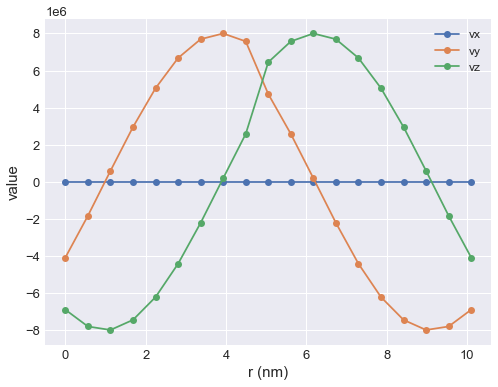

In [44]:
line = system.m.line(p1=system.m.mesh.region.pmin, p2=system.m.mesh.region.pmax, n=19)
line.mpl(marker='o')

### Exercise

Assemble the appropriate energy equation in order to obtain a skyrmion state in a disk with $100 \,\text{nm}$ diameter and $5 \,\text{nm}$ thickness. In addition, choose the appropriate initial magnetisation state.

**Solution**

Running OOMMF (ExeOOMMFRunner) [2020/06/25 12:06]... (1.8 s)


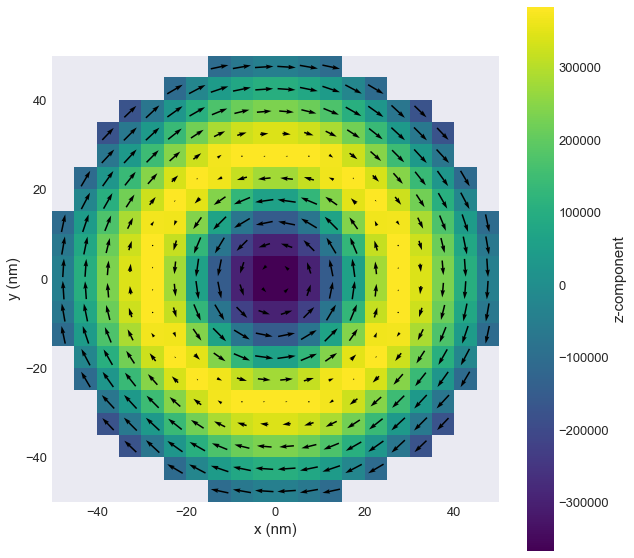

In [31]:
d = 100e-9
thickness = 5e-9
cell = 3*(5e-9,)

p1 = (-d/2, -d/2, 0)
p2 = (d/2, d/2, thickness)
region = df.Region(p1=p1, p2=p2)
mesh = df.Mesh(region=region, cell=cell)
system = mm.System(name='skyrmion')
system.energy = mm.Exchange(A=8.78e-12) + mm.DMI(D=1.58e-3, crystalclass='T') + mm.Demag()

def m_initial(point):
    x, y, z = point
    if x**2 + y**2 < (d/4)**2:
        return (0, 0, -1)
    else:
        return (0, 0, 1)
    
def Ms_fun(point):
    x, y, z = point
    if x**2 + y**2 < (d/2)**2:
        return 3.84e5
    else:
        return 0
    
system.m = df.Field(mesh, dim=3, value=m_initial, norm=Ms_fun)

md.drive(system)

system.m.plane('z').mpl(figsize=(10, 10))

In [32]:
system.m.z.k3d_scalar(filter_field=system.m.norm)

Output()